In [ ]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [131]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines

In [157]:
id = "0-20000-0-06750"

In [158]:
from urllib.request import urlopen
from bs4 import BeautifulSoup


url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
xml = urlopen(url).read()
soup = BeautifulSoup(xml, 'xml')

# Retrieve all of the anchor tags
tags = soup('OAI-PMH')
# print(tags)



In [159]:
%%capture cap --no-stderr
print(tags)

In [160]:
with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    f.write(cap.stdout)

In [161]:
# get variables at a station

observedProperties = []

with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
    observedProperties_line = soup.find_all('observedProperty')
    observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
    observedProperties.append(observedProperties_notation)

from functools import reduce
 
def unique(list1):
    # Print directly by using * symbol
    ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
    return(ans)

variables_u = unique(observedProperties[0])

f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
lines=f.readlines()
all_dates = []

# prepare data frame #
df_station = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "variable"])

for var in variables_u:
    variable = var
    # print("test: ", variable)
    station = id

    # find line numbers containing the WMDR number of the observed property
    numbers = []

    with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
        for num, line in enumerate(myFile, 1):
            if variable in line:
                numbers.append(num)

    # find the line numbers with <om:observedProperty
    obs = "observedProperty"
    numbers_obs = []

    for n in numbers:
        # print("test: ", n)
        if obs in lines[n-1]:
            # print(n)
            number = re.findall(r'\d+',lines[n-1])
            if number[0]==str(var):
                numbers_obs.append(n)

    ### read 20 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
    for n in numbers_obs:
        start = "beginPosition"
        end = "endPosition"
        line_numbers = range(n-50,n)

        f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
        lines=f.readlines()
        positions = []

        for n in line_numbers:
            # print("n: ", n)
            if start in lines[n]:
                beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if beginning:
                    pd.to_datetime(beginning, format='%Y-%m-%d')
                    positions.append(beginning[0])
                else:
                    positions.append(np.nan)
                    
            elif end in lines[n]:
                ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if ending:
                    pd.to_datetime(ending, format='%Y-%m-%d')
                    positions.append(ending[0])
                else:
                    positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

        beginPosition  = positions[0]
        endPosition = positions[1]
        new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":station,"variable":variable}
        df_station.loc[len(df_station)] = new_row 

    
df_station.drop([0], axis=0, inplace=True)
print(df_station)



   beginPosition endPosition          station variable
1     1958-01-01  2005-09-01  0-20000-0-06750       57
2     2005-10-28  2016-03-31  0-20000-0-06750      179
3     1958-01-01  2005-09-01  0-20000-0-06750      179
4     2005-10-28  2016-03-31  0-20000-0-06750      180
5     1958-01-01  2005-09-01  0-20000-0-06750      180
6     2005-09-01  2023-10-20  0-20000-0-06750      210
7     1958-01-01  2005-09-01  0-20000-0-06750      210
8     2005-09-01  2023-10-20  0-20000-0-06750      216
9     1980-01-22  2005-09-01  0-20000-0-06750      216
10    2005-09-01  2023-10-20  0-20000-0-06750      224
11    2004-08-25  2004-08-30  0-20000-0-06750      224
12    2004-08-25  2005-09-01  0-20000-0-06750      224
13    2005-09-01  2023-10-20  0-20000-0-06750      225
14    2004-08-25  2005-09-01  0-20000-0-06750      225
15    2005-09-01  2023-10-20  0-20000-0-06750      226
16    2004-08-25  2005-09-01  0-20000-0-06750      226
17    2005-10-28  2016-03-31  0-20000-0-06750      230
18    1958

In [162]:
# combine 3 dictionaries (Atmosphere, Ocean & Terrestrial)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableAtmosphere_WMDR"+'_dictionary.json') as f:
    dictionary = json.loads(f.read())


with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableOcean_WMDR"+'_dictionary.json') as f:
    dictionary_Ocean = json.loads(f.read())   

dictionary.update(dictionary_Ocean)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableTerrestrial_WMDR"+'_dictionary.json') as f:
    dictionary_Terrestrial = json.loads(f.read())

dictionary.update(dictionary_Terrestrial)

variables = df_station["variable"]

df_station["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]
df_station


,beginPosition,endPosition,station,variable,variables_names
1,1958-01-01,2005-09-01,0-20000-0-06750,57,State of ground
2,2005-10-28,2016-03-31,0-20000-0-06750,179,Cloud amount
3,1958-01-01,2005-09-01,0-20000-0-06750,179,Cloud amount
4,2005-10-28,2016-03-31,0-20000-0-06750,180,Cloud cover
5,1958-01-01,2005-09-01,0-20000-0-06750,180,Cloud cover
6,2005-09-01,2023-10-20,0-20000-0-06750,210,Amount of precipitation
7,1958-01-01,2005-09-01,0-20000-0-06750,210,Amount of precipitation
8,2005-09-01,2023-10-20,0-20000-0-06750,216,Atmospheric pressure
9,1980-01-22,2005-09-01,0-20000-0-06750,216,Atmospheric pressure
10,2005-09-01,2023-10-20,0-20000-0-06750,224,Air temperature (at specified distance from re...


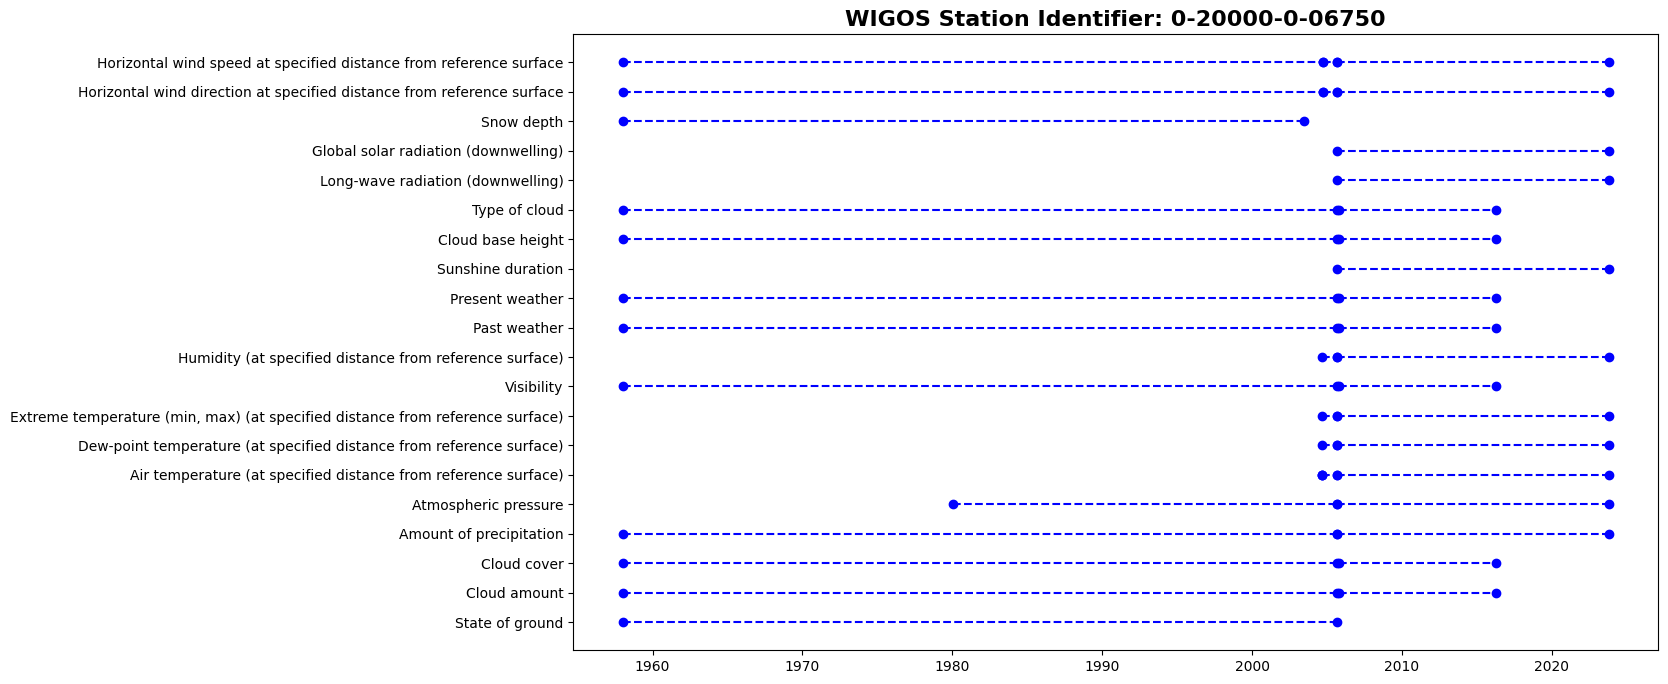

In [163]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,8))

variables = variables_u

for var in range(0,len(variables)):
    df_var = df_station[df_station["variable"]==str(variables[var])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    # print(x_values)
    plt.plot(x_values, [var,var], 'bo', linestyle="--")

# print(variables)
names = []
for var in range(0,len(variables)):
    variable_df = df_station[df_station["variable"]==str(variables[var])]
    name = variable_df.iloc[0]["variables_names"]
    # print(name)
    names.append(name)
n = range(0,len(names))
plt.yticks(n,names)

# title
plt.title("WIGOS Station Identifier: " + id, fontsize=16, fontweight="bold")


# save figure
fig.savefig(os.getcwd()+"/Plots/Deployments_"+id+".jpeg", bbox_inches='tight')